# Imports

In [ ]:
import math
from os import listdir
from os.path import isfile, join
import cv2
import json

## Mount Google Drive
Access datasets, and save results

In [ ]:
from google.colab import drive
drive.mount('/content/drive', True)

Mounted at /content/drive


# Configuration

In [ ]:
fps = 10 # video frame analyze frequency

# dataset paths
videos_path=r"/content/drive/MyDrive/Tal's Folder/Videos"
frames_path=r"/content/drive/MyDrive/Tal's Folder/Frames"
person_path=r"/content/drive/MyDrive/Tal's Folder/person"

# roboflow
roboflow_api_key="####################" # For security reasons I would prefer not to reveal my api key
tagged_false_rescue_sign_path="/content/RescueSign---Dataset-1/train/False"
tagged_true_rescue_sign_path="/content/RescueSign---Dataset-1/train/true"

# OpenPose 
false_json_path = "/content/pose_keypoints/False"
true_json_path = "/content/pose_keypoints/True"

# Split Videos Into Frames
Find all videos in the input dir, and split each of them into frames in the desired frame rate

In [ ]:
def extract_frames(video_file, output_dir, image_index, fps):
  cap = cv2.VideoCapture(video_file)
  
  # get the fps from the video
  frame_rate = cap.get(cv2.CAP_PROP_FPS)    

  while(cap.isOpened()):
    # read video until finished
    ret, frame = cap.read()
    if (ret != True):
      break
    
    # get only frames in the desired FPS
    frame_possition = cap.get(cv2.CAP_PROP_POS_FRAMES)
    if (frame_possition % math.ceil(frame_rate/fps) == 0):
      # save frame as an image file
      filename = join(output_dir, f'{image_index:05d}.jpg')
      if image_index%1000 == 0:
        print(f'Writing frame {filename}')
      cv2.imwrite(filename, frame)
      image_index += 1

  cap.release()
  return image_index

In [ ]:
def split_videos_into_frames(input_dir, output_dir, image_index, fps):
  
  # find all video files
  video_files = [join(input_dir, f) for f in listdir(input_dir) if isfile(join(input_dir, f))]  

  # for each video file, extract frames
  for video_file in video_files:
    print("Extracting frames from " + video_file)
    image_index = extract_frames(video_file, output_dir, image_index, fps)

  return image_index

In [ ]:
# split the images
image_count = split_videos_into_frames(videos_path, frames_path, 0, fps)

print(f"Extracted {image_count} images")

Extracting frames from /content/drive/MyDrive/Tal's Folder/Videos/DJI_0026.MOV
Writing frame /content/drive/MyDrive/Tal's Folder/Frames/00000.jpg
Writing frame /content/drive/MyDrive/Tal's Folder/Frames/01000.jpg
Writing frame /content/drive/MyDrive/Tal's Folder/Frames/02000.jpg
Writing frame /content/drive/MyDrive/Tal's Folder/Frames/03000.jpg
Writing frame /content/drive/MyDrive/Tal's Folder/Frames/04000.jpg
Writing frame /content/drive/MyDrive/Tal's Folder/Frames/05000.jpg
Extracting frames from /content/drive/MyDrive/Tal's Folder/Videos/DJI_0030.MOV
Writing frame /content/drive/MyDrive/Tal's Folder/Frames/06000.jpg
Writing frame /content/drive/MyDrive/Tal's Folder/Frames/07000.jpg
Writing frame /content/drive/MyDrive/Tal's Folder/Frames/08000.jpg
Writing frame /content/drive/MyDrive/Tal's Folder/Frames/09000.jpg
Writing frame /content/drive/MyDrive/Tal's Folder/Frames/10000.jpg
Extracting frames from /content/drive/MyDrive/Tal's Folder/Videos/DJI_0033.MOV
Writing frame /content/dri

# Crop people from frames using YOLOv8
<img src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov8/banner-yolov8.png" />

YOLOv8 is a state of the art real-time object detection algorithm

## Install YOLOv8 dependencies

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.109 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 24.9/166.8 GB disk)


## Run object detection for persopn on extracted frames

In [ ]:
classes=0 # person
conf=0.7 # high confedence for certenty for training data
imgsz=640

!yolo detect predict model=yolov8x.pt source={frames_path} imgsz={imgsz} conf={conf} device=0 save=False save_crop=True show_labels=False show_conf=False classes={classes}

Streaming output truncated to the last 5000 lines.
image 11760/16757 /content/drive/MyDrive/Tal's Folder/Frames/11771.jpg: 384x640 1 person, 12.3ms
image 11761/16757 /content/drive/MyDrive/Tal's Folder/Frames/11772.jpg: 384x640 1 person, 13.3ms
image 11762/16757 /content/drive/MyDrive/Tal's Folder/Frames/11773.jpg: 384x640 1 person, 12.2ms
image 11763/16757 /content/drive/MyDrive/Tal's Folder/Frames/11774.jpg: 384x640 1 person, 12.6ms
image 11764/16757 /content/drive/MyDrive/Tal's Folder/Frames/11775.jpg: 384x640 1 person, 12.6ms
image 11765/16757 /content/drive/MyDrive/Tal's Folder/Frames/11776.jpg: 384x640 1 person, 12.5ms
image 11766/16757 /content/drive/MyDrive/Tal's Folder/Frames/11777.jpg: 384x640 1 person, 12.4ms
image 11767/16757 /content/drive/MyDrive/Tal's Folder/Frames/11778.jpg: 384x640 1 person, 12.4ms
image 11768/16757 /content/drive/MyDrive/Tal's Folder/Frames/11779.jpg: 384x640 1 person, 12.4ms
image 11769/16757 /content/drive/MyDrive/Tal's Folder/Frames/11780.jpg: 384x

# Upload dataset to roboflow
Upload the tagged "person" dataset that we just generated into roboflow

<img src="https://assets.website-files.com/5f6bc60e665f54545a1e52a5/642746dba53a59a614a64b35_roboflow-open-graph.png" />

Using roboflow to save, tag, and manipulate and run augmentations on our dataset

## Install roboflow

In [ ]:
!pip install roboflow

In [ ]:
dir_list = listdir(person_path)

In [ ]:
# importing the roboflow Python Package
from roboflow import Roboflow

# creating the Roboflow object
rf = Roboflow(api_key=roboflow_api_key)

# using the workspace method on the Roboflow object
workspace = rf.workspace()

# identifying the project for upload
project = workspace.project("rescuesign-dataset")

# uploading the images to your project
for i, img in enumerate(dir_list):
    project.upload(os.path.join(person_path, img), num_retry_uploads=10)

loading Roboflow workspace...
loading Roboflow project...


# Download the dataset from roboflow
(after tagging and running augmantations)

In [ ]:
# Download the 
dataset = project.version(1).download("folder")

Extracting Dataset Version Zip to RescueSign---Dataset-1 in folder:: 100%|██████████| 9140/9140 [00:08<00:00, 1082.55it/s]


# Running Pose Estimation
Using Openpose

<img src="https://repository-images.githubusercontent.com/89247811/4a021a80-cc07-11e9-9a7b-5f22f82f360b" />

### Install OpenPose

In [ ]:
import os 
from os.path import exists, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

## Run OpenPose on dataset

In [ ]:
!cd openpose && ./build/examples/openpose/openpose.bin --image_dir {tagged_false_rescue_sign_path} Folder/person --write_json {false_json_path} --display 0 --render_pose 0

In [ ]:
!cd openpose && ./build/examples/openpose/openpose.bin --image_dir {tagged_true_rescue_sign_path} Folder/person --write_json {true_json_path} --display 0 --render_pose 0

In [ ]:
false_json_list = listdir(false_json_path)
true_json_list = listdir(true_json_path)

# Read information from JSON files into list

In [ ]:
def read_jsons_from_directory(json_file_names, dir_path):
  jsons_data = []

  # go over all files and append them to list
  for json_file_name in json_file_names:
    with open(os.path.join(dir_path, json_file_name)) as json_file:
      jsonContent = json_file.read()
      jsons_data.append(json.loads(jsonContent))

  # extract relevant information from entire data into a list
  key_points = []
  for frame, json_file_name in zip(jsons_data, json_file_names):
    for person in frame['people']:
      person_keypoints = person['pose_keypoints_2d']
      key_points.append([[person_keypoints[i], person_keypoints[i+1]] for i in range(0, len(person_keypoints), 3)])


  return key_points

In [ ]:
false_list = read_jsons_from_directory(false_json_list, false_json_path)
true_list = read_jsons_from_directory(true_json_list, true_json_path)

## Train & Validation Split

In [ ]:
from sklearn.model_selection import train_test_split

training_data_F, testing_data_F, training_labels_F, testing_labels_F = train_test_split(false_list, [0]*len(false_list), test_size=0.3, random_state=25)
training_data_T, testing_data_T, training_labels_T, testing_labels_T = train_test_split(true_list, [1]*len(true_list), test_size=0.3, random_state=25)

In [ ]:
training_data   = training_data_F   + training_data_T
testing_data    = testing_data_F    + testing_data_T
training_labels = training_labels_F + training_labels_T
testing_labels  = testing_labels_F  + testing_labels_T

# Train pose classification model

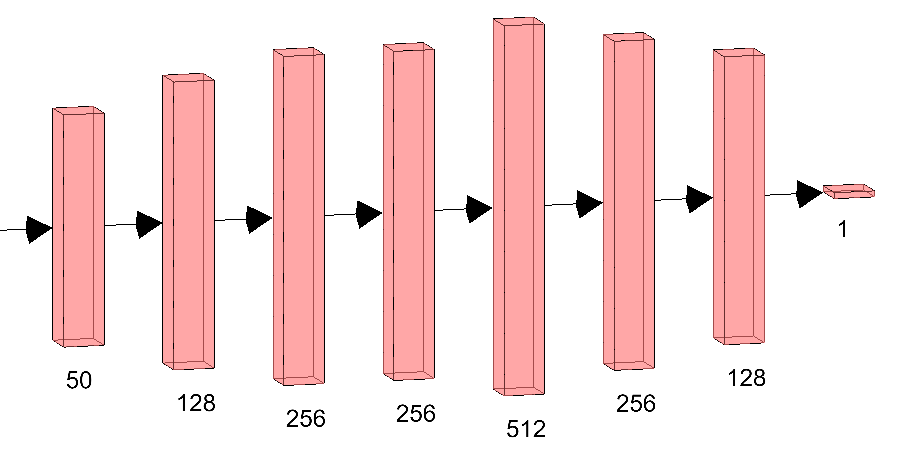

### Build a classification neural network
The output of the network will determine if the recognized pose is classified as a Rescue Sign

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

### Load the dataset into the neural network

In [ ]:
class RescueSignDataset(Dataset):
  def __init__(self, keypoints, labels=None):
    self.keypoints = torch.tensor(keypoints, dtype=torch.float32)
    if labels is not None:
      self.labels = torch.tensor(labels, dtype=torch.float32)
    else:
      self.labels = None

  def __len__(self):
    return len(self.keypoints)

  def __getitem__(self, index):
    if self.labels is not None:
      return self.keypoints[index], self.labels[index]
    return self.keypoints[index]

### Build the network

In [ ]:
class RescueSignNet(nn.Module):
    def __init__(self):
        super(RescueSignNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(50, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.7)
        )
        self.layer5 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.6)
        )
        self.layer6 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )
        self.layer7 = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        return x.view(-1)

### Load the dataset

In [ ]:
train_dataset = RescueSignDataset(training_data, training_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = RescueSignDataset(testing_data, testing_labels)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

### Initialize the model

In [ ]:
model = RescueSignNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RescueSignNet(
  (layer1): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.6, inplace=False)
  )
  (layer4): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.7, inplace=False)
  )
  (layer5): Sequential(
    (0): Line

### Initialize HyperParameters

In [ ]:
learning_rate = 0.001
batch_size = 512
num_epochs = 500

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train the model

In [ ]:
# Define variables to track the best validation accuracy and the corresponding model state
best_val_acc = 0.0
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs.view(-1,50))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted_train = torch.round(outputs)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted_train == labels).sum().item()

    train_acc = total_correct_train / total_samples_train
    train_loss /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.view(-1,50))
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted_val = torch.round(outputs)
            total_samples_val += labels.size(0)
            total_correct_val += (predicted_val == labels).sum().item()

    val_acc = total_correct_val / total_samples_val
    val_loss /= len(valid_loader)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model and its state if the validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        print("model saved!")
    else:
        learning_rate /= 1.05
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print("lr decrease:", learning_rate)

print(f"Best model - Validation accuracy = {best_val_acc}")
# Save the best model state to a file
torch.save(best_model_state, 'RescueSignModel.pt')

Epoch [1/500] - Train Loss: 0.7079, Train Acc: 0.5385, Val Loss: 0.6908, Val Acc: 0.4342
model saved!
Epoch [2/500] - Train Loss: 0.6094, Train Acc: 0.6754, Val Loss: 0.5723, Val Acc: 0.6800
model saved!
Epoch [3/500] - Train Loss: 0.4228, Train Acc: 0.8390, Val Loss: 0.3036, Val Acc: 0.8667
model saved!
Epoch [4/500] - Train Loss: 0.3078, Train Acc: 0.8907, Val Loss: 0.2894, Val Acc: 0.8738
model saved!
Epoch [5/500] - Train Loss: 0.2529, Train Acc: 0.9094, Val Loss: 0.2495, Val Acc: 0.9075
model saved!
Epoch [6/500] - Train Loss: 0.2355, Train Acc: 0.9166, Val Loss: 0.2527, Val Acc: 0.9079
model saved!
Epoch [7/500] - Train Loss: 0.2234, Train Acc: 0.9182, Val Loss: 0.2078, Val Acc: 0.9221
model saved!
Epoch [8/500] - Train Loss: 0.2078, Train Acc: 0.9253, Val Loss: 0.1978, Val Acc: 0.9217
lr decrease: 0.0009523809523809524
Epoch [9/500] - Train Loss: 0.2094, Train Acc: 0.9269, Val Loss: 0.1953, Val Acc: 0.9263
model saved!
Epoch [10/500] - Train Loss: 0.1940, Train Acc: 0.9341, Val 